# Load modules

In [25]:
%load_ext autoreload
%autoreload 2
import scvelo as scv
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyrovelocity.data import load_data
from scipy.stats import spearmanr, pearsonr
from pyrovelocity.api import train_model
import seaborn as sns
import pandas as pd
from pyrovelocity.plot import plot_posterior_time, plot_gene_ranking,\
      vector_field_uncertainty, plot_vector_field_uncertain,\
      plot_mean_vector_field, project_grid_points,rainbowplot,denoised_umap,\
      us_rainbowplot, plot_arrow_examples, set_colorbar
from pyrovelocity.utils import mae, mae_evaluate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download filtered dataset from figshare (https://figshare.com/articles/dataset/larry_invitro_adata_sub_raw_h5ad/20780344)

In [2]:
adata_input = scv.read("larry_invitro_adata_sub_raw.h5ad")
adata_input.layers['raw_spliced']   = adata_input.layers['spliced']
adata_input.layers['raw_unspliced'] = adata_input.layers['unspliced']

In [3]:
scv.pp.filter_and_normalize(adata_input, min_shared_counts=30, n_top_genes=2000)

Filtered out 16583 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [4]:
adata_input.obs['u_lib_size_raw'] = adata_input.layers['raw_spliced'].toarray().sum(-1)
adata_input.obs['s_lib_size_raw'] = adata_input.layers['raw_spliced'].toarray().sum(-1)

In [5]:
scv.pp.moments(adata_input, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Apply Model 2 to all cells in LARRY (multi-fate dataset)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["raw_unspliced"]                                                             
INFO     Using data from adata.layers["raw_spliced"]                                                               
INFO     Successfully registered anndata object containing 49302 cells, 2000 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 49302 │
│             Vars             │ 2000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto
step    0 loss = 2.65312e+08 patience = 45
step  100 loss = 1.84915e+08 patience = 45


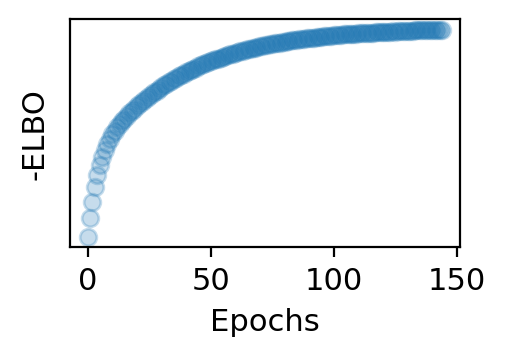

In [6]:
adata_model_pos = train_model(adata_input,
                              max_epochs=1000, svi_train=True, log_every=100,
                              patient_init=45,
                              batch_size=4000, use_gpu=0, cell_state='state_info',
                              include_prior=True,
                              offset=True,
                              library_size=True,
                              patient_improve=1e-3,
                              model_type='auto',
                              guide_type='auto',
                              train_size=1.0)

In [7]:
v_map_all, embeds_radian, fdri = vector_field_uncertainty(adata_input, adata_model_pos[1], 
                                                          basis='emb', denoised=False, n_jobs=30)

computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:02:28) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:47) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:46) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:47) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:51) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:47) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:49) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:45) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:49) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:50) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:47) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:49) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:46) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:46) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:47) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:50) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:47) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)


computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 30/256 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:02:24) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_pyro_emb', embedded velocity vectors (adata.obsm)


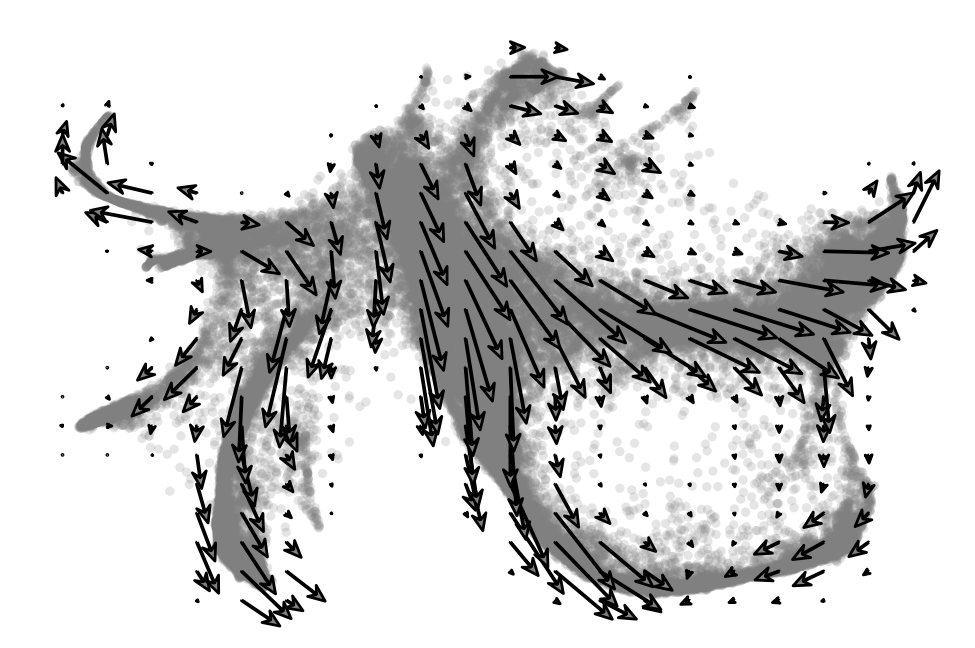

In [14]:
fig, ax = plt.subplots()
embed_mean = plot_mean_vector_field(adata_model_pos[1], adata_input, ax=ax, n_jobs=30, basis='emb')

V_grid.........
60 50 40


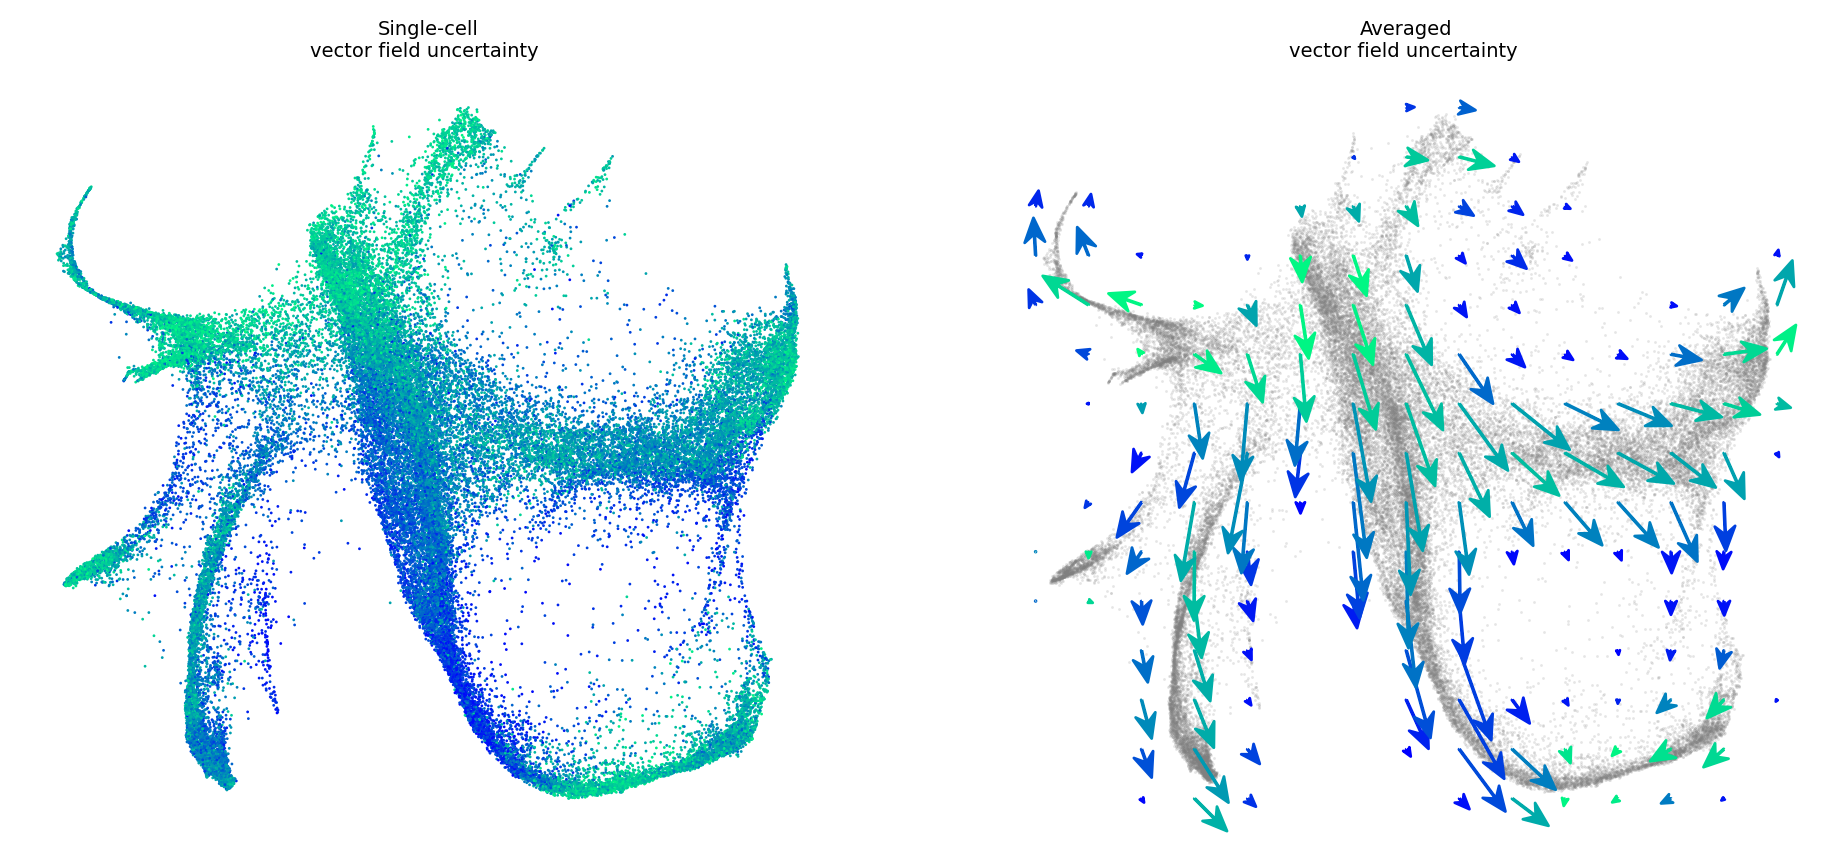

In [18]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.5, 5)
plot_vector_field_uncertain(adata_input, embed_mean, embeds_radian, 
                            ax=ax,
                            fig=fig, cbar=False, basis='emb', scale=None)

# More uncertainty estimation for LARRY

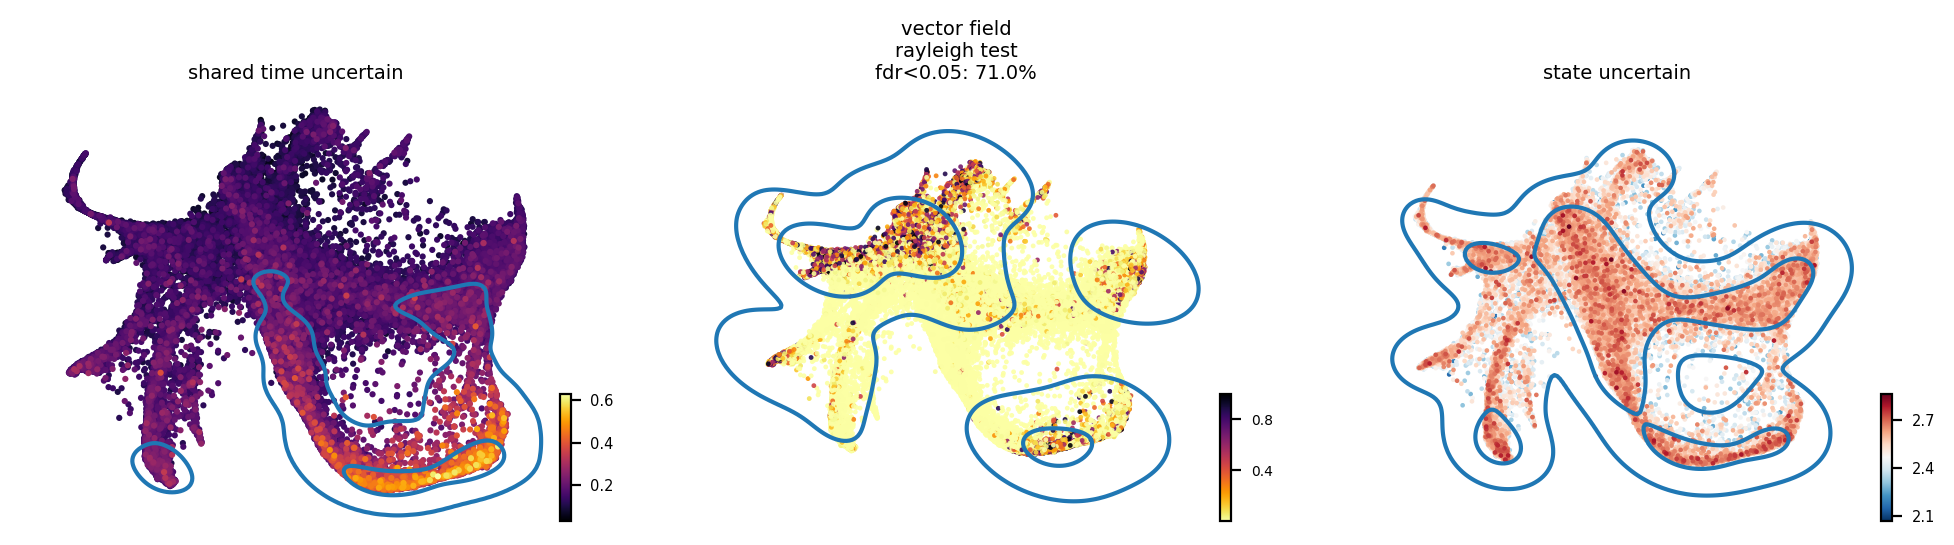

In [33]:
from pyrovelocity.plot import plot_state_uncertainty

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 2.8)
adata_input.obs['shared_time_uncertain'] = adata_model_pos[1]['cell_time'].std(0).flatten()
ax_cb = scv.pl.scatter(adata_input, c='shared_time_uncertain', ax=ax[0], show=False, cmap='inferno', fontsize=7, s=20, colorbar=True, basis='emb')

select = adata_input.obs['shared_time_uncertain'] > np.quantile(adata_input.obs['shared_time_uncertain'], 0.9)
sns.kdeplot(adata_input.obsm['X_emb'][:, 0][select],
            adata_input.obsm['X_emb'][:, 1][select],
            ax=ax[0], levels=3, fill=False)

adata_input.obs.loc[:, 'vector_field_rayleigh_test'] = fdri
basis = 'emb'
im = ax[1].scatter(adata_input.obsm[f'X_{basis}'][:, 0],
                   adata_input.obsm[f'X_{basis}'][:, 1], s=3, alpha=0.9,
                   c=adata_input.obs['vector_field_rayleigh_test'], cmap='inferno_r',
                   linewidth=0)
##ax[1].set_title("Rayleigh test")
set_colorbar(im, ax[1], labelsize=5, fig=fig, position='right')
select = adata_input.obs['vector_field_rayleigh_test'] > np.quantile(adata_input.obs['vector_field_rayleigh_test'], 0.95)
sns.kdeplot(adata_input.obsm['X_emb'][:, 0][select],
            adata_input.obsm['X_emb'][:, 1][select], ax=ax[1], levels=3, fill=False)
ax[1].axis('off')
ax[1].set_title("vector field\nrayleigh test\nfdr<0.05: %s%%" % (round((fdri < 0.05).sum()/fdri.shape[0], 2)*100), fontsize=7)
_ = plot_state_uncertainty(adata_model_pos[1], adata_input, kde=True, data='raw',
                           top_percentile=0.9, ax=ax[2], basis='emb')